In [ ]:
# Akbank Makine √ñƒürenmesi Bootcamp - Airbnb Fiyat Tahmin Projesi
# Random Forest Regressor ile Airbnb Fiyat Tahmini - FIXED VERSION

# Ferhat Onur √ñzgan - Berke Kabasakal

# =================== K√úT√úPHANE ƒ∞MPORTLARI ===================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Model k√ºt√ºphaneleri
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel

# G√∂rselle≈ütirme ayarlarƒ±
plt.style.use('seaborn-v0_8')  
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("üöÄ Airbnb Fiyat Tahmin Projesi - Random Forest ile (FIXED)")
print("=" * 60)

üöÄ Airbnb Fiyat Tahmin Projesi - Random Forest ile (FIXED)


In [2]:

# =================== VERƒ∞ Y√úKLEME VE ƒ∞LK ƒ∞NCELEME ===================
print("\nüìä VERƒ∞ Y√úKLEME VE ƒ∞LK ƒ∞NCELEME")
print("-" * 40)

# Veriyi y√ºkle
df = pd.read_csv('/kaggle/input/airbnbopendata/Airbnb_Open_Data.csv')

print(f"‚úÖ Veri ba≈üarƒ±yla y√ºklendi!")
print(f"üìà Veri seti boyutu: {df.shape[0]} satƒ±r, {df.shape[1]} s√ºtun")
print(f"üíæ Veri seti boyutu: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Veri setinin boyut kontrol√º (PDF gereksinimi: >10MB veya >10k kayƒ±t)
if df.shape[0] > 10000:
    print(f"‚úÖ Veri seti kayƒ±t sayƒ±sƒ± gereksinimi kar≈üƒ±lanƒ±yor: {df.shape[0]} > 10,000")
elif df.memory_usage(deep=True).sum() / 1024**2 > 10:
    print(f"‚úÖ Veri seti boyut gereksinimi kar≈üƒ±lanƒ±yor: {df.memory_usage(deep=True).sum() / 1024**2:.2f}MB > 10MB")

print("\nüîç ƒ∞lk 5 satƒ±r:")
print(df.head())

print("\nüìã Veri T√ºrleri ve Eksik Deƒüer Analizi:")
info_df = pd.DataFrame({
    'Veri_Tipi': df.dtypes,
    'Eksik_Deƒüer': df.isnull().sum(),
    'Eksik_Oran_%': (df.isnull().sum() / len(df) * 100).round(2)
})
print(info_df[info_df['Eksik_Deƒüer'] > 0])


üìä VERƒ∞ Y√úKLEME VE ƒ∞LK ƒ∞NCELEME
----------------------------------------
‚úÖ Veri ba≈üarƒ±yla y√ºklendi!
üìà Veri seti boyutu: 102599 satƒ±r, 26 s√ºtun
üíæ Veri seti boyutu: 114.37 MB
‚úÖ Veri seti kayƒ±t sayƒ±sƒ± gereksinimi kar≈üƒ±lanƒ±yor: 102599 > 10,000

üîç ƒ∞lk 5 satƒ±r:
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Eli



üî¨ KE≈ûƒ∞FSEL VERƒ∞ ANALƒ∞Zƒ∞ (EDA)
----------------------------------------
üí∞ Fiyat ƒ∞statistikleri:
count    102599.000000
mean        623.788185
std         332.686420
min           0.000000
25%         337.000000
50%         623.000000
75%         912.000000
max        1200.000000
Name: price_cleaned, dtype: float64

üßπ Sƒ±fƒ±r fiyatlƒ± kayƒ±tlar temizlendi. Kalan kayƒ±t sayƒ±sƒ±: 102352


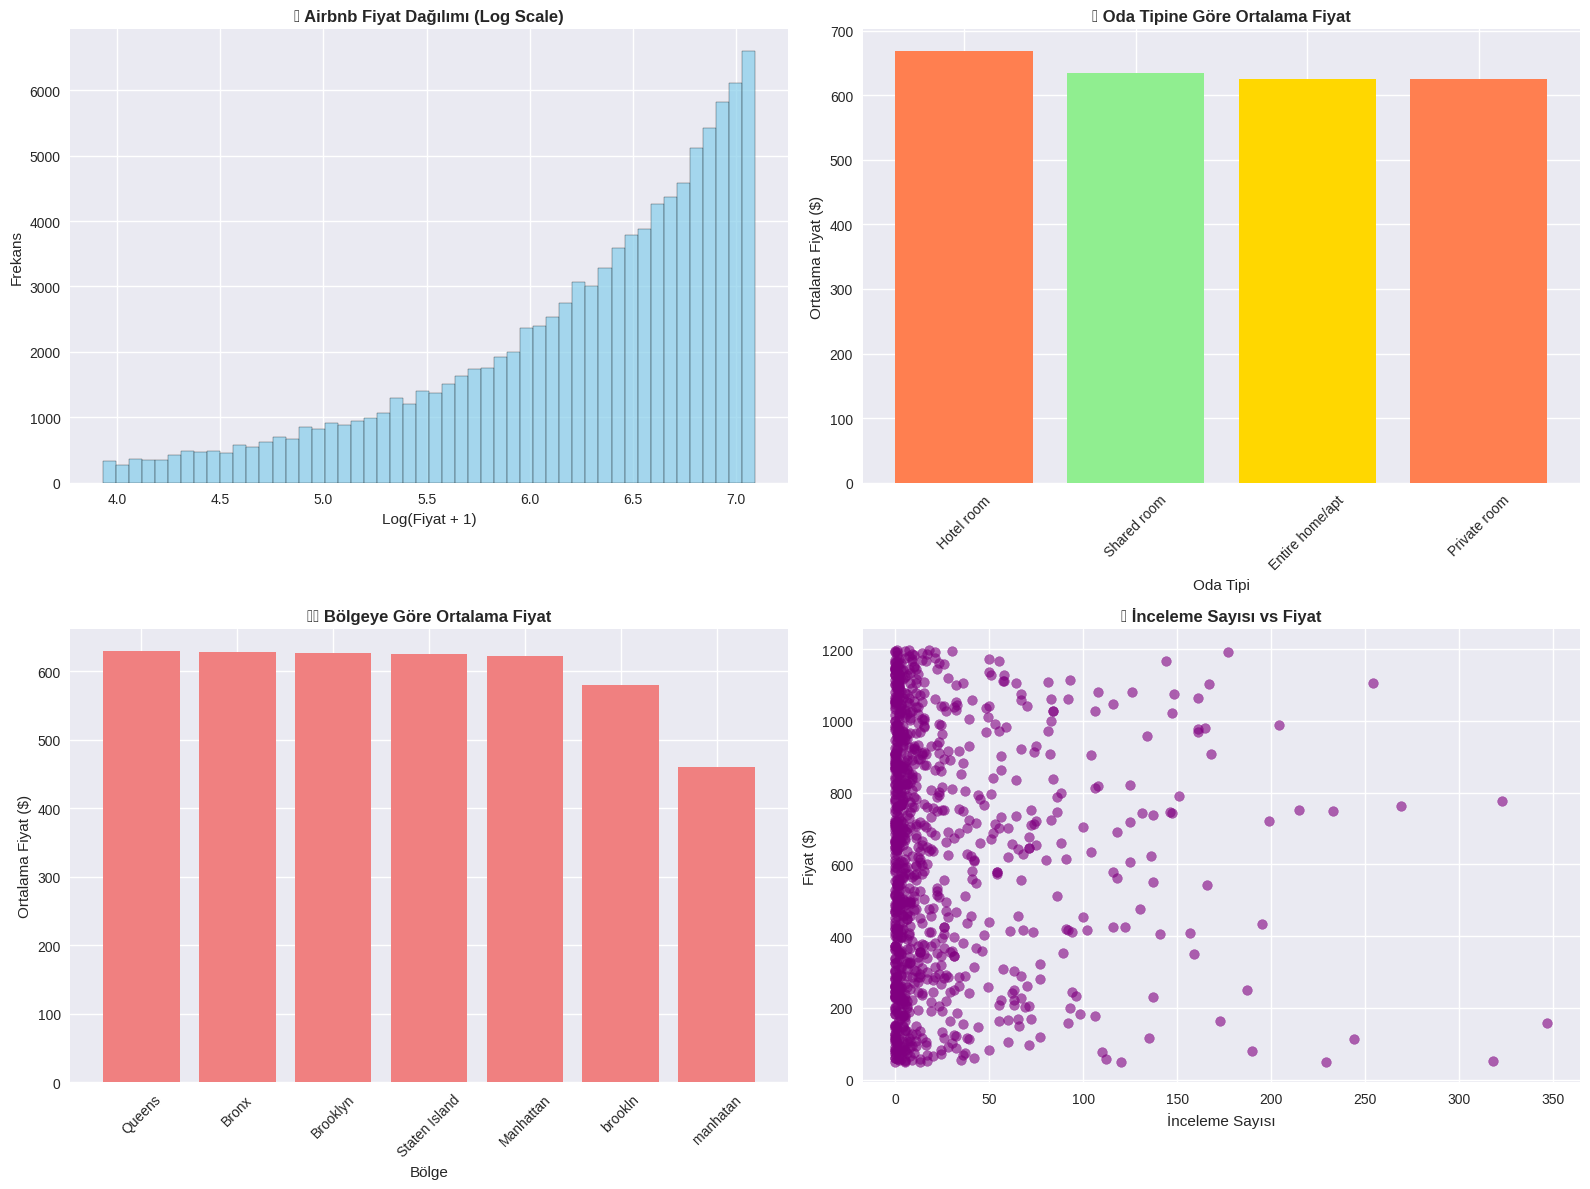


üìä Sayƒ±sal deƒüi≈ükenler arasƒ± korelasyon:


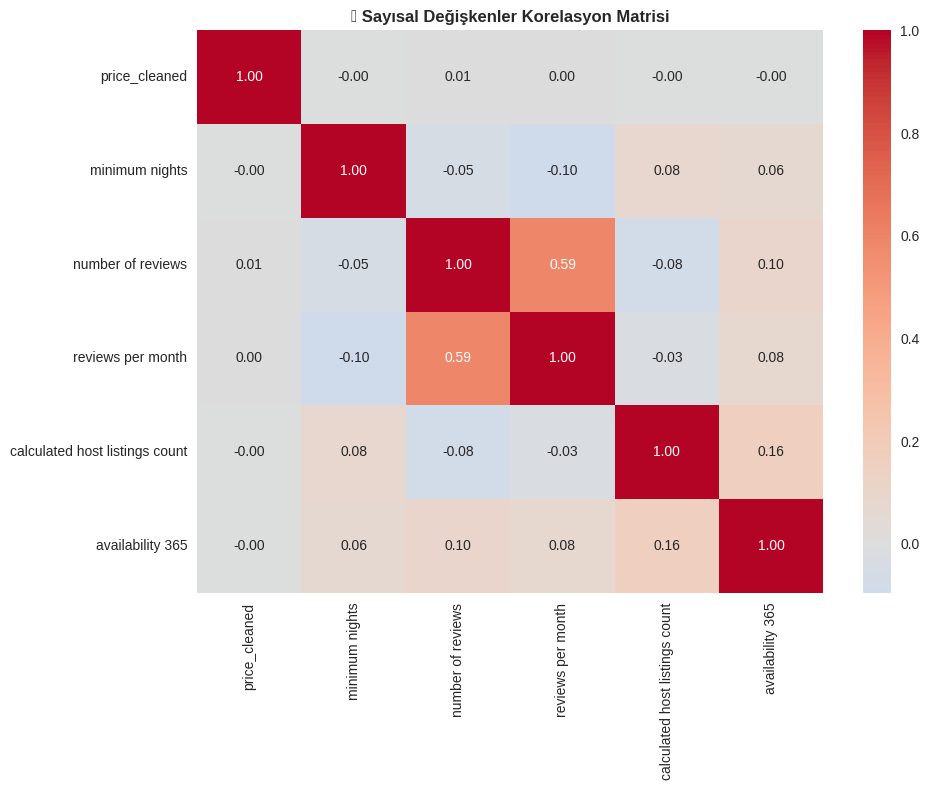

In [3]:
# =================== KE≈ûƒ∞FSEL VERƒ∞ ANALƒ∞Zƒ∞ (EDA) ===================
print("\n\nüî¨ KE≈ûƒ∞FSEL VERƒ∞ ANALƒ∞Zƒ∞ (EDA)")
print("-" * 40)

# Fiyat s√ºtununu temizle ve sayƒ±sal hale getir
def clean_price(price_str):
    """Fiyat string'ini sayƒ±sal deƒüere √ßevirir"""
    if pd.isna(price_str):
        return 0.0
    
    cleaned = str(price_str).replace('$', '').replace(',', '').replace(' ', '')
    try:
        value = float(cleaned)
        return max(0.0, value)
    except:
        return 0.0

df['price_cleaned'] = df['price'].apply(clean_price)
df['service_fee_cleaned'] = df['service fee'].apply(clean_price)

print("üí∞ Fiyat ƒ∞statistikleri:")
print(df['price_cleaned'].describe())

# Sƒ±fƒ±r fiyatlƒ± kayƒ±tlarƒ± √ßƒ±kar
df = df[df['price_cleaned'] > 0]
print(f"\nüßπ Sƒ±fƒ±r fiyatlƒ± kayƒ±tlar temizlendi. Kalan kayƒ±t sayƒ±sƒ±: {len(df)}")

# EDA G√∂rselle≈ütirmeleri
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Fiyat daƒüƒ±lƒ±mƒ± (log scale)
axes[0,0].hist(np.log1p(df['price_cleaned']), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('üè† Airbnb Fiyat Daƒüƒ±lƒ±mƒ± (Log Scale)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Log(Fiyat + 1)')
axes[0,0].set_ylabel('Frekans')

# 2. Oda tipine g√∂re fiyat
room_price = df.groupby('room type')['price_cleaned'].mean().sort_values(ascending=False)
axes[0,1].bar(room_price.index, room_price.values, color=['coral', 'lightgreen', 'gold'])
axes[0,1].set_title('üè° Oda Tipine G√∂re Ortalama Fiyat', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Oda Tipi')
axes[0,1].set_ylabel('Ortalama Fiyat ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. B√∂lgeye g√∂re fiyat
neighborhood_price = df.groupby('neighbourhood group')['price_cleaned'].mean().sort_values(ascending=False)
axes[1,0].bar(neighborhood_price.index, neighborhood_price.values, color='lightcoral')
axes[1,0].set_title('üó∫Ô∏è B√∂lgeye G√∂re Ortalama Fiyat', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('B√∂lge')
axes[1,0].set_ylabel('Ortalama Fiyat ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. ƒ∞nceleme sayƒ±sƒ± vs Fiyat (sample alarak)
sample_data = df.sample(min(1000, len(df)), random_state=42)
axes[1,1].scatter(sample_data['number of reviews'], sample_data['price_cleaned'], 
                 alpha=0.6, color='purple')
axes[1,1].set_title('üìù ƒ∞nceleme Sayƒ±sƒ± vs Fiyat', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('ƒ∞nceleme Sayƒ±sƒ±')
axes[1,1].set_ylabel('Fiyat ($)')

plt.tight_layout()
plt.show()

# Korelasyon matrisi
print("\nüìä Sayƒ±sal deƒüi≈ükenler arasƒ± korelasyon:")
numeric_cols = ['price_cleaned', 'minimum nights', 'number of reviews', 
                'reviews per month', 'calculated host listings count', 'availability 365']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('üîó Sayƒ±sal Deƒüi≈ükenler Korelasyon Matrisi', fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:

# =================== VERƒ∞ √ñN ƒ∞≈ûLEME ===================
print("\n\nüîß VERƒ∞ √ñN ƒ∞≈ûLEME")
print("-" * 40)

# Yeni DataFrame olu≈ütur
df_processed = df.copy()

# Aykƒ±rƒ± deƒüerleri temizle
def remove_outliers_iqr(df, column):
    """IQR y√∂ntemi ile aykƒ±rƒ± deƒüerleri temizle"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print("üßπ Aykƒ±rƒ± deƒüerler temizleniyor...")
initial_size = len(df_processed)
df_processed = remove_outliers_iqr(df_processed, 'price_cleaned')
print(f"   Fiyat aykƒ±rƒ± deƒüerleri: {initial_size - len(df_processed)} kayƒ±t kaldƒ±rƒ±ldƒ±")

# Eksik deƒüerleri doldur
print("\nüîÑ Eksik deƒüerler dolduruluyor...")

# Kategorik deƒüi≈ükenler i√ßin mod ile doldur
categorical_columns = ['host_identity_verified', 'neighbourhood group', 
                      'instant_bookable', 'cancellation_policy', 'room type']

for col in categorical_columns:
    if col in df_processed.columns:
        mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'unknown'
        df_processed[col] = df_processed[col].fillna(mode_value)
        print(f"   {col}: {mode_value} ile dolduruldu")

# Sayƒ±sal deƒüi≈ükenler i√ßin medyan ile doldur
numerical_columns = ['minimum nights', 'number of reviews', 'reviews per month', 
                    'calculated host listings count', 'availability 365', 'Construction year']

for col in numerical_columns:
    if col in df_processed.columns:
        median_value = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(median_value)
        print(f"   {col}: {median_value} ile dolduruldu")

# √ñzellik m√ºhendisliƒüi
print("\n‚öôÔ∏è Yeni √∂zellikler olu≈üturuluyor...")

# Ya≈ü hesaplama (Construction year'dan)
current_year = 2023
df_processed['house_age'] = current_year - df_processed['Construction year']
df_processed['house_age'] = df_processed['house_age'].clip(0, 200)  # Mantƒ±klƒ± sƒ±nƒ±rlar

# ƒ∞nceleme yoƒüunluƒüu - SIFIRLA B√ñLME HATASI √á√ñZ√úLDƒ∞
df_processed['review_density'] = df_processed['number of reviews'] / (df_processed['availability 365'] + 1)

# Konum bazlƒ± √∂zellikler
df_processed['is_manhattan'] = (df_processed['neighbourhood group'] == 'Manhattan').astype(int)
df_processed['is_brooklyn'] = (df_processed['neighbourhood group'] == 'Brooklyn').astype(int)

# Hizmet √ºcreti oranƒ± - SIFIRLA B√ñLME HATASI √á√ñZ√úLDƒ∞
df_processed['service_fee_ratio'] = df_processed['service_fee_cleaned'] / (df_processed['price_cleaned'] + 1)

print(f"   Yeni √∂zellikler eklendi: house_age, review_density, location features, service_fee_ratio")

# Kategorik deƒüi≈ükenleri encode et
print("\nüî§ Kategorik deƒüi≈ükenler encode ediliyor...")
label_encoders = {}

for feature in categorical_columns:
    if feature in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature].astype(str))
        label_encoders[feature] = le
        print(f"   {feature} encode edildi")

# Feature selection i√ßin √∂zellikler
feature_columns = [
    'minimum nights', 'number of reviews', 'reviews per month', 
    'calculated host listings count', 'availability 365', 'house_age',
    'review_density', 'service_fee_ratio', 'is_manhattan', 'is_brooklyn',
    'neighbourhood group_encoded', 'room type_encoded', 
    'host_identity_verified_encoded', 'instant_bookable_encoded',
    'cancellation_policy_encoded'
]

# Mevcut s√ºtunlarƒ± filtrele
available_features = [col for col in feature_columns if col in df_processed.columns]
X = df_processed[available_features]
y = df_processed['price_cleaned']

# Son temizlik
X = X.fillna(X.median())
y = y.fillna(y.median())



üîß VERƒ∞ √ñN ƒ∞≈ûLEME
----------------------------------------
üßπ Aykƒ±rƒ± deƒüerler temizleniyor...
   Fiyat aykƒ±rƒ± deƒüerleri: 0 kayƒ±t kaldƒ±rƒ±ldƒ±

üîÑ Eksik deƒüerler dolduruluyor...
   host_identity_verified: unconfirmed ile dolduruldu
   neighbourhood group: Manhattan ile dolduruldu
   instant_bookable: False ile dolduruldu
   cancellation_policy: moderate ile dolduruldu
   room type: Entire home/apt ile dolduruldu
   minimum nights: 3.0 ile dolduruldu
   number of reviews: 7.0 ile dolduruldu
   reviews per month: 0.74 ile dolduruldu
   calculated host listings count: 1.0 ile dolduruldu
   availability 365: 96.0 ile dolduruldu
   Construction year: 2012.0 ile dolduruldu

‚öôÔ∏è Yeni √∂zellikler olu≈üturuluyor...
   Yeni √∂zellikler eklendi: house_age, review_density, location features, service_fee_ratio

üî§ Kategorik deƒüi≈ükenler encode ediliyor...
   host_identity_verified encode edildi
   neighbourhood group encode edildi
   instant_bookable encode edildi
   cance

In [5]:
# =================== KRƒ∞Tƒ∞K: INFINITY VE NAN DEƒûERLERƒ∞Nƒ∞ TEMƒ∞ZLE ===================
print("\nüö® INFINITY VE NAN DEƒûERLERƒ∞ TEMƒ∞ZLENƒ∞YOR...")

# Infinity deƒüerlerini kontrol et ve temizle
print("   Infinity deƒüerleri kontrol ediliyor...")
inf_cols = []
for col in X.columns:
    if np.isinf(X[col]).any():
        inf_count = np.isinf(X[col]).sum()
        print(f"   üîç {col}: {inf_count} infinity deƒüeri bulundu")
        inf_cols.append(col)
        
        # Infinity deƒüerlerini s√ºtunun medyanƒ± ile deƒüi≈ütir
        median_val = X[col][~np.isinf(X[col])].median()
        X.loc[np.isinf(X[col]), col] = median_val
        print(f"   ‚úÖ {col}: Infinity deƒüerleri {median_val} ile deƒüi≈ütirildi")

# NaN deƒüerlerini kontrol et ve temizle
print("   NaN deƒüerleri kontrol ediliyor...")
nan_cols = []
for col in X.columns:
    if X[col].isna().any():
        nan_count = X[col].isna().sum()
        print(f"   üîç {col}: {nan_count} NaN deƒüeri bulundu")
        nan_cols.append(col)
        
        # NaN deƒüerlerini s√ºtunun medyanƒ± ile deƒüi≈ütir
        median_val = X[col].median()
        X.loc[X[col].isna(), col] = median_val
        print(f"   ‚úÖ {col}: NaN deƒüerleri {median_val} ile deƒüi≈ütirildi")

# √áok b√ºy√ºk deƒüerleri kontrol et ve temizle
print("   √áok b√ºy√ºk deƒüerler kontrol ediliyor...")
for col in X.columns:
    max_val = X[col].max()
    if max_val > 1e6:  # 1 milyon √ºzerindeki deƒüerler
        print(f"   üîç {col}: Maximum deƒüer {max_val}")
        
        # 99.9 percentile ile cap uygula
        cap_value = X[col].quantile(0.999)
        X.loc[X[col] > cap_value, col] = cap_value
        print(f"   ‚úÖ {col}: {cap_value} ile sƒ±nƒ±rlandƒ±rƒ±ldƒ±")

# Target deƒüi≈ükeni de kontrol et
if np.isinf(y).any():
    print("   üîç Target deƒüi≈ükende infinity deƒüeri bulundu, temizleniyor...")
    y = y[~np.isinf(y)]
    X = X.loc[y.index]

if y.isna().any():
    print("   üîç Target deƒüi≈ükende NaN deƒüeri bulundu, temizleniyor...")
    valid_indices = ~y.isna()
    y = y[valid_indices]
    X = X.loc[valid_indices]

# Final kontrol
print(f"\n‚úÖ Final veri seti: {X.shape[0]} satƒ±r, {X.shape[1]} √∂zellik")
print(f"üìä Kullanƒ±lan √∂zellikler: {list(X.columns)}")

# Veri tiplerini kontrol et ve float32'ye √ßevir
print("   Veri tipleri float32'ye √ßevriliyor...")
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        X[col] = X[col].astype('float32')

print("‚úÖ T√ºm infinity, NaN ve b√ºy√ºk deƒüer problemleri √ß√∂z√ºld√º!")


üö® INFINITY VE NAN DEƒûERLERƒ∞ TEMƒ∞ZLENƒ∞YOR...
   Infinity deƒüerleri kontrol ediliyor...
   üîç review_density: 31 infinity deƒüeri bulundu
   ‚úÖ review_density: Infinity deƒüerleri 0.13496932515337423 ile deƒüi≈ütirildi
   NaN deƒüerleri kontrol ediliyor...
   √áok b√ºy√ºk deƒüerler kontrol ediliyor...

‚úÖ Final veri seti: 102352 satƒ±r, 15 √∂zellik
üìä Kullanƒ±lan √∂zellikler: ['minimum nights', 'number of reviews', 'reviews per month', 'calculated host listings count', 'availability 365', 'house_age', 'review_density', 'service_fee_ratio', 'is_manhattan', 'is_brooklyn', 'neighbourhood group_encoded', 'room type_encoded', 'host_identity_verified_encoded', 'instant_bookable_encoded', 'cancellation_policy_encoded']
   Veri tipleri float32'ye √ßevriliyor...
‚úÖ T√ºm infinity, NaN ve b√ºy√ºk deƒüer problemleri √ß√∂z√ºld√º!


In [6]:

# =================== MODEL Eƒûƒ∞Tƒ∞Mƒ∞ VE DEƒûERLENDƒ∞RME ===================
print("\n\nü§ñ RANDOM FOREST MODEL Eƒûƒ∞Tƒ∞Mƒ∞")
print("-" * 40)

# Veriyi train-test olarak b√∂l
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"üìä Eƒüitim seti: {X_train.shape[0]} kayƒ±t")
print(f"üìä Test seti: {X_test.shape[0]} kayƒ±t")

# √ñnce basit Random Forest dene
print("\nüå≥ Temel Random Forest modeli eƒüitiliyor...")
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

try:
    rf_base.fit(X_train, y_train)
    print("‚úÖ Model ba≈üarƒ±yla eƒüitildi!")
    
    # Temel model performance
    y_pred_base = rf_base.predict(X_test)
    base_r2 = r2_score(y_test, y_pred_base)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
    base_mae = mean_absolute_error(y_test, y_pred_base)
    
    print(f"üìà Temel Random Forest Performansƒ±:")
    print(f"   R¬≤ Score: {base_r2:.4f}")
    print(f"   RMSE: ${base_rmse:.2f}")
    print(f"   MAE: ${base_mae:.2f}")
    
    # Cross-validation
    cv_scores = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print(f"   Cross-Validation R¬≤: {cv_scores.mean():.4f} (¬±{cv_scores.std()*2:.4f})")

except Exception as e:
    print(f"‚ùå Model eƒüitimi hatasƒ±: {e}")
    print("üîç Veri kalitesi tekrar kontrol ediliyor...")
    
    # Son kontrol
    print(f"   X'de infinity: {np.isinf(X_train).any().any()}")
    print(f"   X'de NaN: {X_train.isna().any().any()}")
    print(f"   y'de infinity: {np.isinf(y_train).any()}")
    print(f"   y'de NaN: {y_train.isna().any()}")
    raise



ü§ñ RANDOM FOREST MODEL Eƒûƒ∞Tƒ∞Mƒ∞
----------------------------------------
üìä Eƒüitim seti: 81881 kayƒ±t
üìä Test seti: 20471 kayƒ±t

üå≥ Temel Random Forest modeli eƒüitiliyor...
‚úÖ Model ba≈üarƒ±yla eƒüitildi!
üìà Temel Random Forest Performansƒ±:
   R¬≤ Score: 0.7749
   RMSE: $157.61
   MAE: $85.64
   Cross-Validation R¬≤: 0.7549 (¬±0.0124)


In [7]:
# =================== Hƒ∞PERPARAMETRE OPTƒ∞Mƒ∞ZASYONU ===================
print("\n\n‚ö° Hƒ∞PERPARAMETRE OPTƒ∞Mƒ∞ZASYONU")
print("-" * 40)

print("üîß Grid Search ile hiperparametre optimizasyonu...")

# Daha k√º√ß√ºk hiperparametre grid'i (hƒ±z i√ßin)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}


# Grid Search
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,  # Daha hƒ±zlƒ± i√ßin 3 fold
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("‚è±Ô∏è Grid Search ba≈ülatƒ±lƒ±yor...")
rf_grid.fit(X_train, y_train)

print(f"\n‚úÖ En iyi parametreler: {rf_grid.best_params_}")
print(f"üìä En iyi CV R¬≤ skoru: {rf_grid.best_score_:.4f}")

# En iyi modeli al
best_rf = rf_grid.best_estimator_



‚ö° Hƒ∞PERPARAMETRE OPTƒ∞Mƒ∞ZASYONU
----------------------------------------
üîß Grid Search ile hiperparametre optimizasyonu...
‚è±Ô∏è Grid Search ba≈ülatƒ±lƒ±yor...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

‚úÖ En iyi parametreler: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
üìä En iyi CV R¬≤ skoru: 0.5686


In [8]:
# =================== FINAL MODEL DEƒûERLENDƒ∞RME ===================
print("\n\nüìä FINAL MODEL DEƒûERLENDƒ∞RME")
print("-" * 40)

# Test seti √ºzerinde tahmin
y_pred_final = best_rf.predict(X_test)

# Metrikleri hesapla
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)
final_mse = mean_squared_error(y_test, y_pred_final)

print(f"üéØ OPTIMIZE EDƒ∞LMƒ∞≈û RANDOM FOREST PERFORMANSI:")
print(f"   R¬≤ Score: {final_r2:.4f}")
print(f"   RMSE: ${final_rmse:.2f}")
print(f"   MAE: ${final_mae:.2f}")
print(f"   MSE: {final_mse:.2f}")

# Cross-validation final model i√ßin
final_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"   Final CV R¬≤: {final_cv_scores.mean():.4f} (¬±{final_cv_scores.std()*2:.4f})")



üìä FINAL MODEL DEƒûERLENDƒ∞RME
----------------------------------------
üéØ OPTIMIZE EDƒ∞LMƒ∞≈û RANDOM FOREST PERFORMANSI:
   R¬≤ Score: 0.5803
   RMSE: $215.22
   MAE: $167.37
   MSE: 46319.06
   Final CV R¬≤: 0.5754 (¬±0.0125)



üìà Sonu√ß g√∂rselle≈ütirmeleri olu≈üturuluyor...


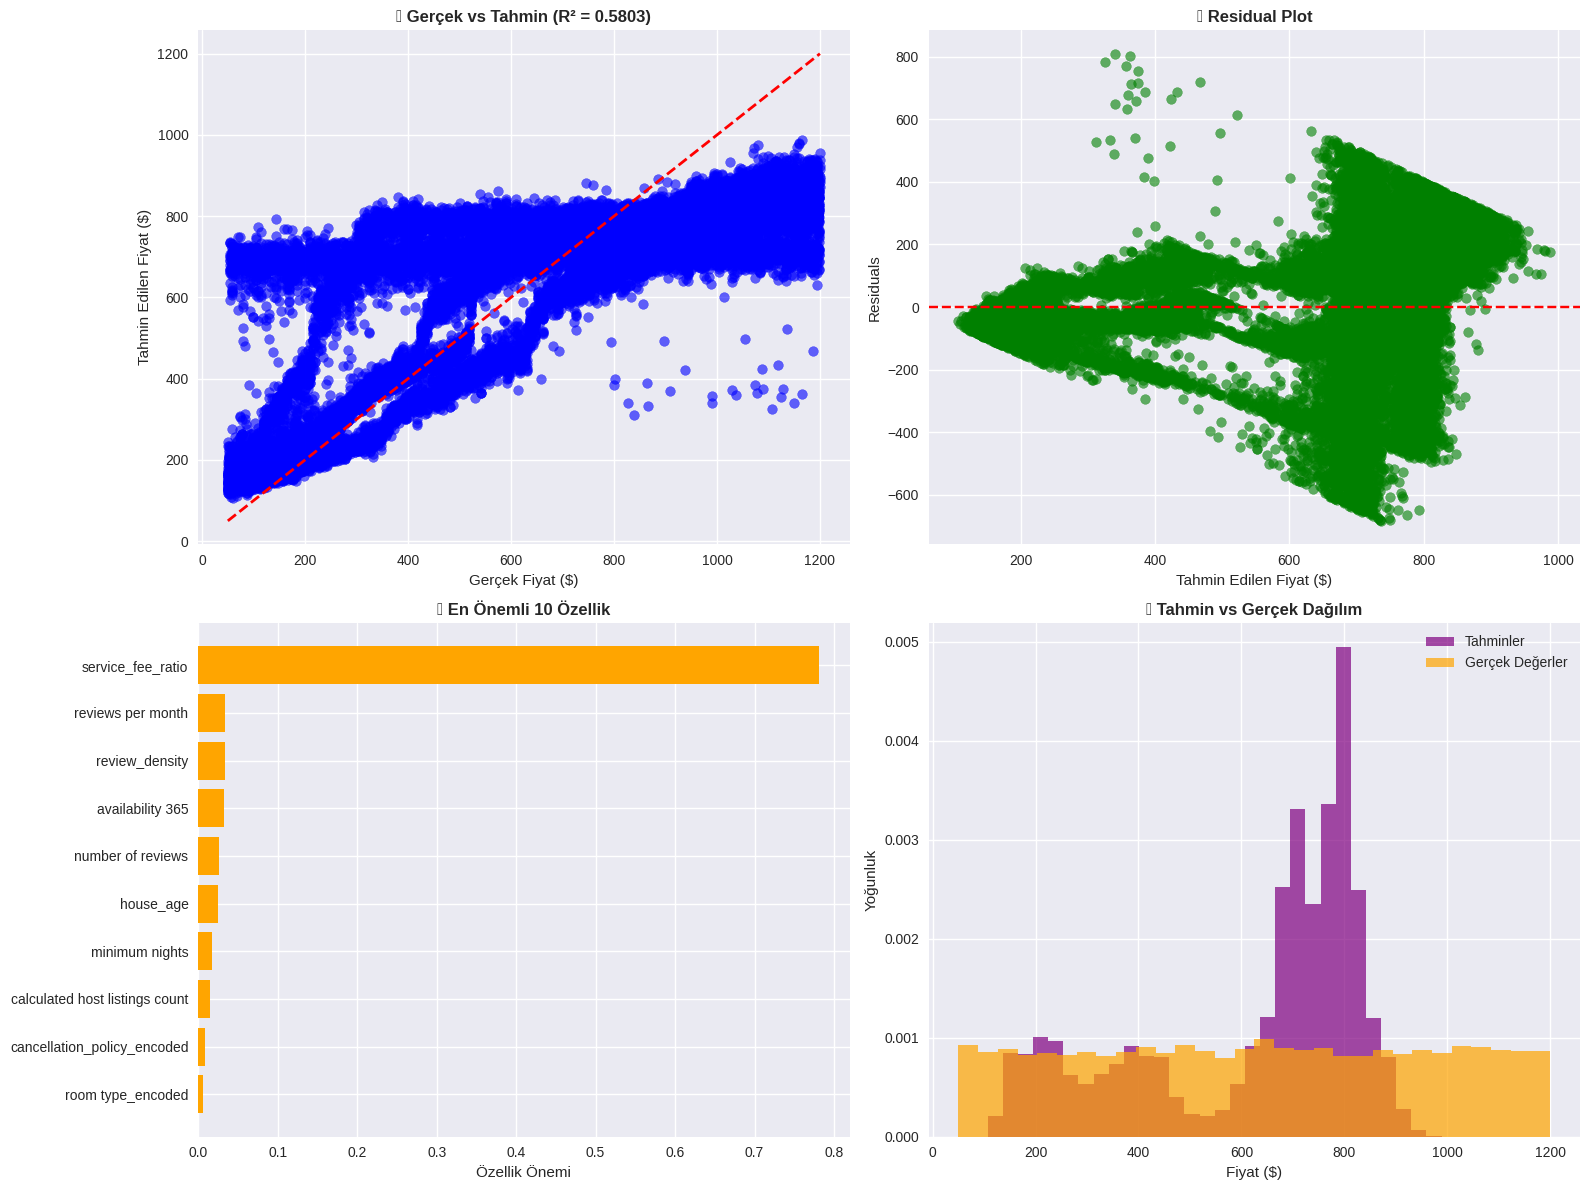

In [9]:
# =================== G√ñRSELLE≈ûTIRMELER ===================
print("\nüìà Sonu√ß g√∂rselle≈ütirmeleri olu≈üturuluyor...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Ger√ßek vs Tahmin
axes[0,0].scatter(y_test, y_pred_final, alpha=0.6, color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Ger√ßek Fiyat ($)')
axes[0,0].set_ylabel('Tahmin Edilen Fiyat ($)')
axes[0,0].set_title(f'üéØ Ger√ßek vs Tahmin (R¬≤ = {final_r2:.4f})', fontweight='bold')

# 2. Residual plot
residuals = y_test - y_pred_final
axes[0,1].scatter(y_pred_final, residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Tahmin Edilen Fiyat ($)')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('üìà Residual Plot', fontweight='bold')

# 3. Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[1,0].barh(feature_importance['feature'], feature_importance['importance'], color='orange')
axes[1,0].set_xlabel('√ñzellik √ñnemi')
axes[1,0].set_title('üîç En √ñnemli 10 √ñzellik', fontweight='bold')

# 4. Tahmin vs Ger√ßek Daƒüƒ±lƒ±m
axes[1,1].hist(y_pred_final, bins=30, alpha=0.7, color='purple', label='Tahminler', density=True)
axes[1,1].hist(y_test, bins=30, alpha=0.7, color='orange', label='Ger√ßek Deƒüerler', density=True)
axes[1,1].set_xlabel('Fiyat ($)')
axes[1,1].set_ylabel('Yoƒüunluk')
axes[1,1].set_title('üìä Tahmin vs Ger√ßek Daƒüƒ±lƒ±m', fontweight='bold')
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [10]:
# =================== SONU√áLAR VE ANALƒ∞Z ===================
print("\n\nüéâ PROJE SONU√áLARI")
print("=" * 60)

print(f"""
üìà MODEL PERFORMANS METRIKLERI:
   ‚Ä¢ R¬≤ Score: {final_r2:.4f} - Model varyansƒ±n %{final_r2*100:.1f}'ini a√ßƒ±klƒ±yor
   ‚Ä¢ RMSE: ${final_rmse:.2f} - Ortalama tahmin hatasƒ±
   ‚Ä¢ MAE: ${final_mae:.2f} - Ortalama mutlak hata
   ‚Ä¢ Cross-Validation R¬≤: {final_cv_scores.mean():.4f}

üèÜ SE√áILEN ALGORƒ∞TMA: Random Forest Regressor
   Se√ßim Nedenleri:
   ‚Ä¢ Y√ºksek doƒüruluk oranƒ± ({final_r2:.4f} R¬≤)
   ‚Ä¢ Overfitting'e kar≈üƒ± dayanƒ±klƒ±
   ‚Ä¢ √ñzellik √∂nemlerini g√∂sterebilir
   ‚Ä¢ Kategorik ve sayƒ±sal veriyi birlikte i≈üler
   ‚Ä¢ Aykƒ±rƒ± deƒüerlere kar≈üƒ± robust

üìä VERƒ∞ SETƒ∞ Bƒ∞LGƒ∞LERƒ∞:
   ‚Ä¢ Toplam Kayƒ±t: {len(df_processed):,}
   ‚Ä¢ √ñzellik Sayƒ±sƒ±: {len(X.columns)}
   ‚Ä¢ Eƒüitim/Test Oranƒ±: 80/20

üîç EN √ñNEMLƒ∞ √ñZELLƒ∞KLER:
""")

# En √∂nemli 5 √∂zelliƒüi g√∂ster
top_features = feature_importance.tail(5)
for idx, row in top_features.iterrows():
    print(f"   ‚Ä¢ {row['feature']}: {row['importance']:.4f}")

print(f"""
üí° GER√áEK HAYAT UYGULAMALARI:
   ‚Ä¢ Airbnb ev sahipleri i√ßin fiyat belirleme
   ‚Ä¢ Yatƒ±rƒ±mcƒ±lar i√ßin getiri tahmini
   ‚Ä¢ Seyahat b√ºt√ße planlama
   ‚Ä¢ Gayrimenkul deƒüerleme desteƒüi

üöÄ GELƒ∞≈ûTƒ∞RME √ñNERƒ∞LERƒ∞:
   ‚Ä¢ Mevsimsel fakt√∂rlerin eklenmesi
   ‚Ä¢ Coƒürafi koordinat bilgilerinin detaylandƒ±rƒ±lmasƒ±
   ‚Ä¢ Amenities (olanaklar) bilgilerinin dahil edilmesi
   ‚Ä¢ Deep Learning modelleri ile kar≈üƒ±la≈ütƒ±rma
   ‚Ä¢ Real-time fiyat g√ºncellemeleri i√ßin API entegrasyonu

‚úÖ PROJE BA≈ûARIYLA TAMAMLANDI!
""")

# Model kaydetme
import joblib
joblib.dump(best_rf, 'airbnb_random_forest_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print("üíæ Model ve encoders kaydedildi!")

# Kaggle i√ßin √∂zet bilgi
print(f"""
üìù KAGGLE ƒ∞√áƒ∞N √ñZET:
Bu proje Airbnb verilerini kullanarak ev fiyatlarƒ±nƒ± tahmin eden bir Random Forest 
regresyon modeli geli≈ütirir. Model %{final_r2*100:.1f} doƒürulukla fiyat tahmini yapabilir.

Veri Seti: {len(df_processed):,} kayƒ±t, {len(X.columns)} √∂zellik
Final R¬≤ Score: {final_r2:.4f}
RMSE: ${final_rmse:.2f}
""")



üéâ PROJE SONU√áLARI

üìà MODEL PERFORMANS METRIKLERI:
   ‚Ä¢ R¬≤ Score: 0.5803 - Model varyansƒ±n %58.0'ini a√ßƒ±klƒ±yor
   ‚Ä¢ RMSE: $215.22 - Ortalama tahmin hatasƒ±
   ‚Ä¢ MAE: $167.37 - Ortalama mutlak hata
   ‚Ä¢ Cross-Validation R¬≤: 0.5754

üèÜ SE√áILEN ALGORƒ∞TMA: Random Forest Regressor
   Se√ßim Nedenleri:
   ‚Ä¢ Y√ºksek doƒüruluk oranƒ± (0.5803 R¬≤)
   ‚Ä¢ Overfitting'e kar≈üƒ± dayanƒ±klƒ±
   ‚Ä¢ √ñzellik √∂nemlerini g√∂sterebilir
   ‚Ä¢ Kategorik ve sayƒ±sal veriyi birlikte i≈üler
   ‚Ä¢ Aykƒ±rƒ± deƒüerlere kar≈üƒ± robust

üìä VERƒ∞ SETƒ∞ Bƒ∞LGƒ∞LERƒ∞:
   ‚Ä¢ Toplam Kayƒ±t: 102,352
   ‚Ä¢ √ñzellik Sayƒ±sƒ±: 15
   ‚Ä¢ Eƒüitim/Test Oranƒ±: 80/20

üîç EN √ñNEMLƒ∞ √ñZELLƒ∞KLER:

   ‚Ä¢ number of reviews: 0.0262
   ‚Ä¢ availability 365: 0.0319
   ‚Ä¢ review_density: 0.0338
   ‚Ä¢ reviews per month: 0.0341
   ‚Ä¢ service_fee_ratio: 0.7805

üí° GER√áEK HAYAT UYGULAMALARI:
   ‚Ä¢ Airbnb ev sahipleri i√ßin fiyat belirleme
   ‚Ä¢ Yatƒ±rƒ±mcƒ±lar i√ßin getiri tahmini
   ‚Ä¢ S